In [70]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import biotite.structure.io.pdb as pdb
import biotite.structure.info as info
import biotite.structure as struc
import biotite.structure.io as strucio

In [ ]:
base_dir = "/workspaces/tcr_structure_embedding/killing_assay/tcrmodel2_out"

rows = []

for tcr in os.listdir(base_dir):
    if tcr.startswith("tcr"):

        pdb_path = Path(base_dir, tcr, "ranked_0.pdb")
        pdb_file = pdb.PDBFile.read(pdb_path)
        pdb1 = pdb_file.get_structure()
        if len(pdb1) > 1:
            raise ValueError(f"{pdb_path} has more than 1 model.")

        triplets, mask = struc.hbond(pdb1)

        for donor, h, acceptor in triplets:
            if pdb1.chain_id[donor] == pdb1.chain_id[acceptor]:
                continue
            # Coordinates
            d_coord = pdb1.coord[0][donor]
            h_coord = pdb1.coord[0][h]
            a_coord = pdb1.coord[0][acceptor]
        
            # Compute angle D–H···A (in degrees)
            v_DA = a_coord - d_coord            # vector D -> A
            DA_len = float(np.linalg.norm(v_DA))  # magnitude
            v_DA_unit = v_DA / DA_len if DA_len > 0 else np.zeros(3)
            DA_dist = np.linalg.norm(v_DA)
            
            v_dh = d_coord - h_coord
            v_ah = a_coord - h_coord
            HA_dist = np.linalg.norm(v_ah)
            cos_angle = np.dot(v_dh, v_ah) / (np.linalg.norm(v_dh) * np.linalg.norm(v_ah))
            # numerical stability
            cos_angle = np.clip(cos_angle, -1.0, 1.0)
            angle = np.degrees(np.arccos(cos_angle))


            rows.append({
                "tcr": tcr,
                "d_chainid": pdb1.chain_id[donor],
                "d_resid": pdb1.res_id[donor],
                "d_resname": pdb1.res_name[donor],
                "d_a": pdb1.atom_name[donor],
                "h_chainid": pdb1.chain_id[h],
                "h_resid": pdb1.res_id[h],
                "h_resname": pdb1.res_name[h],
                "h_a": pdb1.atom_name[h],
                "a_chainid": pdb1.chain_id[acceptor],
                "a_resid": pdb1.res_id[acceptor],
                "a_resname": pdb1.res_name[acceptor],
                "a_a": pdb1.atom_name[acceptor],
                "DA_dist": DA_dist,
                "HA_dist": HA_dist,
                "angle": angle,
                # vector DA
                "v_DA_x": v_DA[0],
                "v_DA_y": v_DA[1],
                "v_DA_z": v_DA[2],
                "DA_len": DA_len,
                "u_DA_x": v_DA_unit[0],
                "u_DA_y": v_DA_unit[1],
                "u_DA_z": v_DA_unit[2],
            })

df = pd.DataFrame(rows)

yes = ['tcr100','tcr102','tcr107','tcr43','tcr76','tcr475','tcr173','tcr371',
       'tcr425','tcr450','tcr452','tcr149','tcr159','tcr363','tcr374','tcr462',
       'tcr7','tcr168','tcr212','tcr296','tcr177','tcr181','tcr214','tcr20']

no = ['tcr14', 'tcr420', 'tcr520','tcr417']

df['label'] = ['yes' if tcr in yes else 'no' for tcr in df['tcr']]

df.to_csv(Path(base_dir, "hbond.csv"), index=False)

/opt/conda/lib/python3.12/site-packages/biotite/structure/hbond.py:267: UserWarning: Input structure has no associated 'BondList', Hydrogen atoms bonded to donors are detected by distance
  warnings.warn(


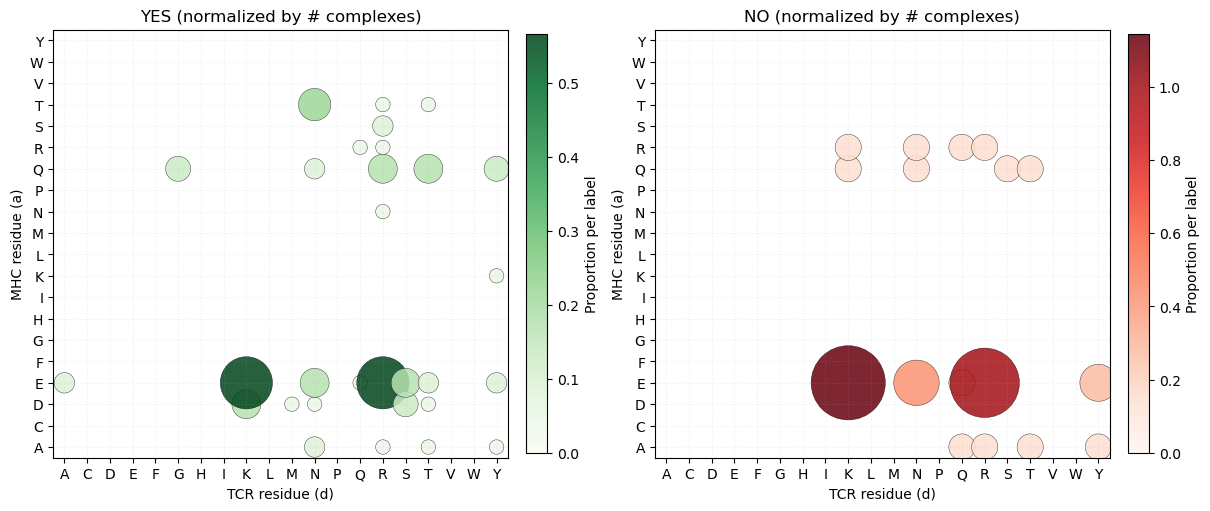

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- choose AA order (1-letter shown on axes, mapped from your 3-letter codes) ---
AA1 = list("ACDEFGHIKLMNPQRSTVWY")
AA3_to_1 = {
    "ALA":"A","CYS":"C","ASP":"D","GLU":"E","PHE":"F","GLY":"G","HIS":"H","ILE":"I",
    "LYS":"K","LEU":"L","MET":"M","ASN":"N","PRO":"P","GLN":"Q","ARG":"R","SER":"S",
    "THR":"T","VAL":"V","TRP":"W","TYR":"Y",
}

# --- filter to the pairs you want (as you did) ---
pairs = df[(df['d_chainid'].isin(['D','E'])) & (df['a_chainid']=='A')]

# If you have a per-complex id (e.g., 'tcr' or 'complex'), set it here; else None.
complex_col = next((c for c in ['tcr','complex','complex_id','pdbid'] if c in pairs.columns), None)

# --- count occurrences per label / (d_resname, a_resname) ---
counts = (pairs
          .assign(d1=pairs['d_resname'].map(AA3_to_1),
                  a1=pairs['a_resname'].map(AA3_to_1))
          .dropna(subset=['d1','a1'])      # drop non-standard residues
          .groupby(['label','d1','a1'])
          .size()
          .rename('count')
          .reset_index())

# --- build full 20x20 grid for each label (fill missing with 0) ---
def complete_grid(label):
    grid = pd.MultiIndex.from_product([[label], AA1, AA1], names=['label','d1','a1']).to_frame(index=False)
    out = grid.merge(counts, on=['label','d1','a1'], how='left').fillna({'count':0})
    return out

yes_grid = complete_grid('yes')
no_grid  = complete_grid('no')

# --- normalization denominator per label ---
def label_denominator(label_df, label_name):
    # Prefer number of UNIQUE complexes in this label if available
    if complex_col is not None:
        n_complex = pairs.loc[pairs['label']==label_name, complex_col].nunique()
        if n_complex and not np.isnan(n_complex):
            return float(n_complex)
    # Fallback: total counts in this subset for that label
    return float(label_df['count'].sum()) if label_df['count'].sum() > 0 else 1.0

den_yes = label_denominator(yes_grid, 'yes')
den_no  = label_denominator(no_grid,  'no')

yes_grid['prop'] = yes_grid['count'] / den_yes
no_grid['prop']  = no_grid['count']  / den_no

# --- plotting helper (mirrored style not needed; we want 2 panels) ---
def bubble_panel(ax, data, title, cmap='Blues', s_scale=2500):
    # pivot to ensure consistent placement
    # x: d (TCR residue), y: a (MHC residue)
    # We scatter from long-form so we can size by 'prop'
    x_idx = {aa:i for i,aa in enumerate(AA1)}
    y_idx = {aa:i for i,aa in enumerate(AA1)}
    x = data['d1'].map(x_idx).to_numpy()
    y = data['a1'].map(y_idx).to_numpy()
    s = (data['prop'].to_numpy()) * s_scale  # scale bubble areas

    sc = ax.scatter(x, y, s=s, c=data['prop'], cmap=cmap, alpha=0.85, edgecolor='k', linewidths=0.3)
    ax.set_xticks(range(len(AA1))); ax.set_xticklabels(AA1, rotation=0)
    ax.set_yticks(range(len(AA1))); ax.set_yticklabels(AA1)
    ax.set_xlabel("TCR residue (d)")
    ax.set_ylabel("MHC residue (a)")
    ax.set_title(title)
    ax.set_xlim(-0.5, len(AA1)-0.5); ax.set_ylim(-0.5, len(AA1)-0.5)
    ax.grid(True, ls=":", alpha=0.2)
    return sc

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

sc1 = bubble_panel(axes[0], yes_grid, title=f"YES (normalized by {('# complexes' if complex_col else 'total contacts')})", cmap='Greens')
sc2 = bubble_panel(axes[1], no_grid,  title=f"NO (normalized by {('# complexes' if complex_col else 'total contacts')})",  cmap='Reds')

# shared colorbars
cbar1 = fig.colorbar(sc1, ax=axes[0], fraction=0.046, pad=0.04); cbar1.set_label("Proportion per label")
cbar2 = fig.colorbar(sc2, ax=axes[1], fraction=0.046, pad=0.04); cbar2.set_label("Proportion per label")

plt.show()


In [71]:
import subprocess
    
def get_cdr_sequence(sequence):
    command = ["bash", "/workspaces/tcr_structure_embedding/structure_feature/sequence/alignment/run_anarci.sh", 
            "-i", str(sequence), 
            "-s", "a"]
    command.append("--assign_germline")
    result = subprocess.run(command, capture_output=True, text=True, check=True)

    lines = result.stdout.strip().split("#")
    alignment = lines[-1]
    alignment = alignment.strip().split("\n")[1:]
    alignment = [a.strip().split() for a in alignment if a.strip() != '//']
    if len(alignment) == 0:
        return None
    
    chain_type = np.unique([a[0] for a in alignment if (len(a)==3)])
    if len(chain_type) != 1:
        raise TypeError(f"{len(chain_type)} chains detected")
    
    fr1 = [a[2] for a in alignment if (len(a)==3) and (int(a[1]) < 25) and (a[2].isalpha())]
    cdr1 = [a[2] for a in alignment if (len(a)==3) and (int(a[1]) >= 25) and (int(a[1]) <= 42) and (a[2].isalpha())]
    fr2 = [a[2] for a in alignment if (len(a)==3) and (int(a[1]) > 42) and (int(a[1]) < 58) and (a[2].isalpha())]
    cdr2 = [a[2] for a in alignment if (len(a)==3) and (int(a[1]) >= 58) and (int(a[1]) <= 77) and (a[2].isalpha())]
    fr3 = [a[2] for a in alignment if (len(a)==3) and (int(a[1]) > 77) and (int(a[1]) < 107) and (a[2].isalpha())]
    cdr3 = [a[2] for a in alignment if (len(a)==3) and (int(a[1]) >= 107) and (int(a[1]) <= 138) and (a[2].isalpha())]
    fr4 = [a[2] for a in alignment if (len(a)==3) and (int(a[1]) > 138) and (a[2].isalpha())]
    return chain_type[0], ''.join(fr1), ''.join(cdr1), ''.join(fr2), ''.join(cdr2), ''.join(fr3), ''.join(cdr3), ''.join(fr4)

In [73]:
tcr_aligned = dict()
for tcr in os.listdir(base_dir):
    if 'tcr' in tcr:
        pdb_path = Path(base_dir, tcr, "ranked_0_proj.pdb")
        if not pdb_path.exists():
            print(f"⚠️ Missing {pdb_path}")
            continue

        pdb_file = pdb.PDBFile.read(pdb_path)
        pdb1 = pdb_file.get_structure()
        if len(pdb1) > 1:
            raise ValueError(f"{pdb_path} has more than 1 model.")
        obj = pdb1[0]
        
        out = dict()
        out['object'] = obj
        chain_ids = struc.get_chains(obj)
        seqs, _ = struc.to_sequence(obj)
        sequences = {c: s for c, s in zip(chain_ids, seqs)}
        out["chainid_to_seq"] = sequences

        # ---------- α chain ----------
        alpha_seq_full = sequences.get("D")
        if not alpha_seq_full:
            print(f"⚠️ No α chain (D) found in {tcr}")
            continue

        aligned = get_cdr_sequence(str(alpha_seq_full))
        if aligned is None:
            print(f"⚠️ Alignment failed for α in {tcr}")
            continue

        _, fr1, cdr1, fr2, cdr2, fr3, cdr3, fr4 = aligned
        alpha_seq = []
        for region, seq_region in zip(
            ["fr1", "cdr1", "fr2", "cdr2", "fr3", "cdr3", "fr4"],
            [fr1, cdr1, fr2, cdr2, fr3, cdr3, fr4],
        ):
            seqlen = len(seq_region)
            middle = seqlen // 2
            for i, aa in enumerate(seq_region):
                if i < middle:
                    position = str(i + 1)
                else:
                    position = str(-(seqlen - i))
                alpha_seq.append(f"{region}:{position}")

        out["alpha_labeled"] = alpha_seq

        # ---------- β chain ----------
        beta_seq_full = sequences.get("E")
        if not beta_seq_full:
            print(f"⚠️ No β chain (E) found in {tcr}")
            continue

        aligned = get_cdr_sequence(str(beta_seq_full))
        if aligned is None:
            print(f"⚠️ Alignment failed for β in {tcr}")
            continue

        _, fr1, cdr1, fr2, cdr2, fr3, cdr3, fr4 = aligned
        beta_seq = []
        for region, seq_region in zip(
            ["fr1", "cdr1", "fr2", "cdr2", "fr3", "cdr3", "fr4"],
            [fr1, cdr1, fr2, cdr2, fr3, cdr3, fr4],
        ):
            seqlen = len(seq_region)
            middle = seqlen // 2
            for i, aa in enumerate(seq_region):
                if i < middle:
                    position = str(i + 1)
                else:
                    position = str(-(seqlen - i))
                beta_seq.append(f"{region}:{position}")

        out["beta_labeled"] = beta_seq
        
        tcr_aligned[tcr] = out

        print(f"{tcr}: α={len(alpha_seq)} residues, β={len(beta_seq)} residues")


tcr425: α=112 residues, β=115 residues
tcr156: α=110 residues, β=118 residues
tcr363: α=116 residues, β=115 residues
tcr102: α=116 residues, β=115 residues
tcr159: α=112 residues, β=116 residues
tcr168: α=114 residues, β=113 residues
tcr7: α=114 residues, β=113 residues
tcr14: α=113 residues, β=116 residues
tcr181: α=113 residues, β=117 residues
tcr520: α=113 residues, β=115 residues
tcr76: α=116 residues, β=115 residues
tcr371: α=109 residues, β=115 residues
tcr517: α=109 residues, β=113 residues
tcr173: α=114 residues, β=115 residues
tcr462: α=111 residues, β=113 residues
tcr452: α=109 residues, β=114 residues
tcr214: α=112 residues, β=115 residues
tcr420: α=114 residues, β=113 residues
⚠️ Missing /workspaces/tcr_structure_embedding/killing_assay/tcrmodel2_out/tcr_projection.pt/ranked_0_proj.pdb
tcr475: α=116 residues, β=115 residues
tcr215: α=108 residues, β=118 residues
tcr212: α=114 residues, β=113 residues
tcr417: α=113 residues, β=113 residues
tcr107: α=116 residues, β=115 resid

In [112]:
d_annot = []
a_annot = []
    
def annotate(obj, chainid, resid):
        resids= struc.get_residues(obj['object'][obj['object'].chain_id==chainid])[0]
        idxs = np.where(resids == resid)[0]
        if idxs.size > 0:
            idx = int(idxs[0])
            if chainid == 'D':
                annotation = obj['alpha_labeled'][idx]
            elif chainid == 'E':
                annotation = obj['beta_labeled'][idx]
            else:
                annotation = resid
            return annotation
        else:
            return resid

for index, row in df.iterrows():
    row['tcr'] = tcr
    obj = tcr_aligned[tcr]
    
    d_annot.append(annotate(obj, row['d_chainid'], row['d_resid']))
    a_annot.append(annotate(obj, row['a_chainid'], row['a_resid']))


In [114]:
df['d_annot']=d_annot
df['a_annot']=a_annot

In [137]:
tcra_pep = (
    df[((df["d_chainid"].isin(["D"])) & (df["a_chainid"] == "A")) | ((df["a_chainid"].isin(["D"])) & (df["d_chainid"] == "A"))]
    .groupby(["label", "tcr"])["tcr"]
    .value_counts()
    .rename("count")
    .reset_index()
)
tcrb_pep = (
    df[((df["d_chainid"].isin(["E"])) & (df["a_chainid"] == "A")) | ((df["a_chainid"].isin(["E"])) & (df["d_chainid"] == "A"))]
    .groupby(["label", "tcr"])["tcr"]
    .value_counts()
    .rename("count")
    .reset_index()
)

tcra_mhc = (
    df[((df["d_chainid"].isin(["D"])) & (df["a_chainid"] == "C")) | ((df["a_chainid"].isin(["D"])) & (df["d_chainid"] == "C"))]
    .groupby(["label", "tcr"])["tcr"]
    .value_counts()
    .rename("count")
    .reset_index()
)
tcrb_mhc = (
    df[((df["d_chainid"].isin(["E"])) & (df["a_chainid"] == "C")) | ((df["a_chainid"].isin(["E"])) & (df["d_chainid"] == "C"))]
    .groupby(["label", "tcr"])["tcr"]
    .value_counts()
    .rename("count")
    .reset_index()
)